In [122]:
import pandas as pd
import seaborn as sns
import os
import json
import datetime
import tldextract

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

## Getting Browser History Data

In [67]:
with open('Takeout\Chrome\BrowserHistory.json', encoding='utf8') as f:
    print(type(f))
    data = json.loads(f.read())
    df = pd.DataFrame(data['Browser History'])
    # A possible param if differentiation is needed b/w different clients
    
df.drop('client_id', axis=1, inplace=True)
# df.drop('favicon_url', axis=1, inplace=True)
df.head()   

<class '_io.TextIOWrapper'>


,page_transition,time_usec,title,url
0,GENERATED,1517589953942148,scorpio price - Google Search,https://www.google.co.in/search?q=scorpio+pric...
1,GENERATED,1517589952292445,seinfeld - Google Search,https://www.google.co.in/search?q=seinfeld&oq=...
2,GENERATED,1517589941514500,poppies seeds - Google Search,https://www.google.co.in/search?q=poppies+seed...
3,LINK,1517589928735099,Buy Namaste India Poppy Seeds/Khus Khus 100 gm...,https://grofers.com/prn/Namaste-India-Poppy-Se...
4,GENERATED,1517589922281270,poppies seeds - Google Search,https://www.google.co.in/search?q=poppies+seed...


In [68]:
df['page_transition'].value_counts()

LINK             3814
RELOAD            834
GENERATED         384
AUTO_TOPLEVEL     352
AUTO_BOOKMARK     337
FORM_SUBMIT       317
TYPED              28
Name: page_transition, dtype: int64

In [69]:
#page_transition: Contains info on the type of page open like reload, type & enter, link open etc.

df1 = df[(df['page_transition'] == 'LINK') | (df['page_transition'] == 'TYPED') | (df['page_transition'] == 'GENERATED')]
df1.shape

(4226, 4)

In [70]:
df1.head()

,page_transition,time_usec,title,url
0,GENERATED,1517589953942148,scorpio price - Google Search,https://www.google.co.in/search?q=scorpio+pric...
1,GENERATED,1517589952292445,seinfeld - Google Search,https://www.google.co.in/search?q=seinfeld&oq=...
2,GENERATED,1517589941514500,poppies seeds - Google Search,https://www.google.co.in/search?q=poppies+seed...
3,LINK,1517589928735099,Buy Namaste India Poppy Seeds/Khus Khus 100 gm...,https://grofers.com/prn/Namaste-India-Poppy-Se...
4,GENERATED,1517589922281270,poppies seeds - Google Search,https://www.google.co.in/search?q=poppies+seed...


In [71]:
df1['page_transition'].value_counts()

LINK         3814
GENERATED     384
TYPED          28
Name: page_transition, dtype: int64

## Extracting/Extrapolating new columns(features):

In [124]:
def convert_time(x):
    return datetime.datetime.fromtimestamp(x/1000000)

days_arr = ["Mon","Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

def get_day_of_week(x):
    return days_arr[x.weekday()]

def get_month(x):
    return x.day

def get_year(x):
    return x.year

def get_hour(x):
    return x.hour

def is_weekend(x):
    if x in ['Sat', 'Sun']:
        return 'Yes'
    else:
        return 'No'
    
def get_domain(x):
    domain = tldextract.extract(x)[1]
    sub_domain = tldextract.extract(x)[0]
    if sub_domain == "mail":
        return sub_domain + "." + domain
    # Ugly hack to differentiate b/w drive.google.com and google.com
    if domain == "google" and sub_domain=="www":
        return "google_search" 
    return domain


# time_usec column is picked and for each row, convert_time(row) is called. The result is stored in the same dataframe under column dt
df1['dt'] = df1['time_usec'].apply(convert_time)
df1['domain'] = df1['url'].apply(get_domain)

In [125]:
df1['month'] = df1['dt'].apply(get_month)
df1['year'] = df1['dt'].apply(get_year)
df1['day'] = df1['dt'].apply(get_day_of_week)
df1['hour'] = df1['dt'].apply(get_hour)

In [131]:
df1['is_weekend'] = df1['day'].apply(is_weekend)

In [132]:
def get_category(x):
    if x in ["coursera", "udacity", "edx", "kaggle", "freecodecamp"]:
        return "Learning"
    elif x in ["ycombinator", "medium", "hackernoon"]:
        return "TechReads"
    elif x in ['facebook', 'twitter']:
        return "Social_media"
    elif x in ['flipkart', 'amazon', 'ebay']:
        return "Shopping"
    else:
        return "Other"

In [133]:
# Cluster popular domains into a category
df1['category'] = df1['domain'].apply(get_category)

In [134]:
df1.category.value_counts()

Social_media    2234
Other           1904
Shopping          76
Learning           7
TechReads          5
Name: category, dtype: int64

In [135]:
df1.columns

Index(['page_transition', 'time_usec', 'title', 'url', 'dt', 'domain',
       'category', 'month', 'year', 'day', 'hour', 'is_weekend'],
      dtype='object')

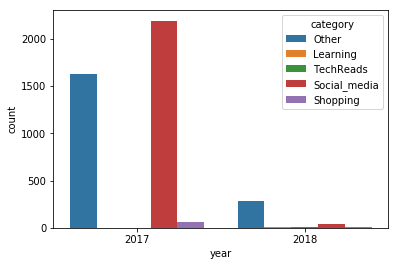

In [130]:
sns.countplot(x='year', hue='category', data=df1)

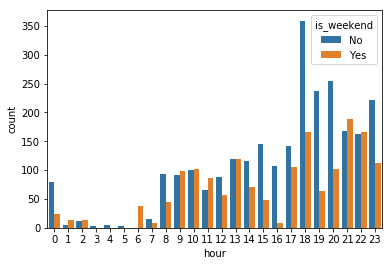

In [140]:
sns.countplot(x='hour', hue='is_weekend', data=df1)